# Libraries

In [126]:
import pandas as pd
import numpy as np
import warnings
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import json
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Loading the processed Data

In [96]:
X_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_train.csv')
X_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_test.csv')
y_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_train.csv')['Class']
y_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_test.csv')['Class']
X_train_res = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_train_res.csv')
y_train_res = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_train_res.csv')['Class']

In [97]:
y_train = y_train.ravel()
y_test = y_test.ravel()
y_train_res = y_train_res.ravel()

# Model

## Training on imbalanced data

In [98]:
model = DecisionTreeClassifier(random_state=42,class_weight='balanced')

In [99]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [100]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1',n_jobs=-1)

In [101]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='f1')

In [102]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
Best score: 0.6971519932971318


In [103]:
best_model = random_search.best_estimator_

In [104]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [105]:
y_pred = best_model.predict(X_test)

## Training on balanced data

In [116]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='precision',n_jobs=-1)

In [117]:
random_search.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='precision')

In [118]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3, 'criterion': 'entropy'}
Best score: 0.9978255634712583


In [119]:
best_model = random_search.best_estimator_

In [120]:
best_model.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)

In [121]:
y_pred = best_model.predict(X_test)

## Pruning

In [149]:
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [151]:
param_grid = {
    'max_depth': [ 5,10,15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5,8],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': np.linspace(min(ccp_alphas[ccp_alphas > 0]), max(ccp_alphas) / 2, 5)
}

In [154]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='precision',n_jobs=-1)

In [155]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': array([1.63683408e-19, 4.57035519e-02, 9.14071038e-02, 1.37110656e-01,
       1.82814208e-01]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [2, 5, 8],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='precision')

In [156]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': np.float64(1.6368340796593418e-19)}
Best score: 0.6613923458622385


In [157]:
best_model = random_search.best_estimator_

In [158]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(1.6368340796593418e-19),
                       class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_leaf=2, random_state=42)

In [159]:
y_pred = best_model.predict(X_test)

## Cost Sensitive

In [163]:
param_grid = {
    'max_depth': [ 5,10,15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5,8],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0: 1, 1: w} for w in [10, 50, 100, 200]]
}

In [166]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='precision',n_jobs=-1)

In [167]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 10},
                                                         {0: 1, 1: 50},
                                                         {0: 1, 1: 100},
                                                         {0: 1, 1: 200}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [2, 5, 8],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='precision')

In [168]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 10}}
Best score: 0.804334460089782


In [169]:
best_model = random_search.best_estimator_

In [170]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                       max_depth=5, min_samples_leaf=8, min_samples_split=10,
                       random_state=42)

In [171]:
y_pred = best_model.predict(X_test)

# Evaluation

In [172]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [173]:
metrics = {
    'Accuracy': float(accuracy),
    'Precision': float(precision),
    'Recall': float(recall),
    'F1-score': float(f1),
    'True Positives': float(tp),
    'False Positives': float(fp)
}
with open('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/costsensitive_metrics.json', 'w') as f:
    json.dump(metrics, f,indent=4)

# pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(30).to_csv('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/pruned_results.csv')

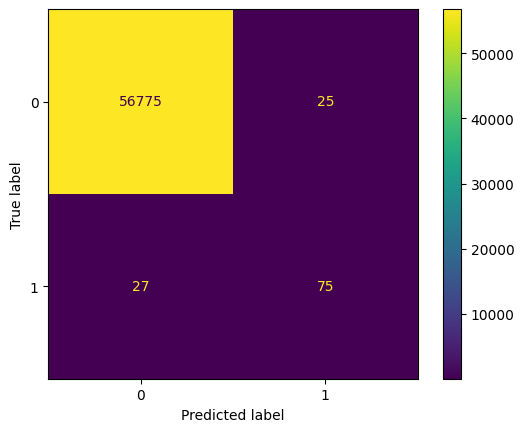

In [108]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()